## Cleanup Previo
En el respositorio del proyecto se encuentran dos pequeños scripts de Python, `download.py` y `rewrite.py`. Estos scripts fueron ejecutados para descargar el set de datos de la página provista, y juntar los resultados (varios archivos `.csv`) en un sólo archivo, a través de `pandas`. A partir de este último, se hace un filtrado de los resultados por ubicación de las propiedades, para quedarnos solo con las del Gran Buenos Aires. Este último DataFrame es el punto de partida de nuestro análisis exploratorio, y para no tener que correr la limpieza cada vez que se trabaja sobre él, se guarda en un csv nuevo.

In [2]:
import pandas as pd
import numpy as np
import mplleaflet
import matplotlib.pyplot as plt
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
%matplotlib inline  

## Carga de datos
Cargo solo las columnas que nos pueden llegar a interesar. En particular, ignoro varias que tienen URL a imágenes y descripciones de las propiedades individuales. 

In [13]:
dtypes = {
    'country_name': str,
    'expenses': object,
    'id': str,
    'title': str,
    'state_name': str,
    'lat': float,
    'lon': float
}
cols = range(6) + range(8, 18) + [20, 21] + range(23, 27)
df = pd.read_csv('data/data_gba_total.csv', dtype=dtypes, usecols=cols)


In [3]:
len(df)

2409471

In [4]:
df.head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
0,Argentina,2015-07-01,USD,1500.0,NaN,3430234.0,-34.574594,"-34.5745944268,-58.4192548517",-58.419255,sell,...,71000.0,1133763.5,71000.0,2448.275862,apartment,1.0,29.0,NaN,29.0,Departamento en Palermo
1,Argentina,2015-07-01,USD,1.0,NaN,3427455.0,-34.610611,"-34.6106110157,-58.4795902886",-58.479590,sell,...,96000.0,1532976.0,96000.0,2285.714286,apartment,2.0,42.0,NaN,47.0,SAN BLAS 2700 6º- A ESTRENAR
2,Argentina,2015-07-01,USD,1.0,NaN,3427455.0,-34.610611,"-34.6106110157,-58.4795902886",-58.479590,sell,...,86000.0,1373291.0,86000.0,2047.619048,apartment,2.0,42.0,NaN,47.0,SAN BLAS 2700 4º- A ESTRENAR
3,Argentina,2015-07-01,USD,NaN,NaN,3436134.0,-34.639086,"-34.639086,-58.369347",-58.369347,sell,...,165000.0,2634802.5,165000.0,2115.384615,apartment,1.0,78.0,NaN,86.0,DEPARTAMENTO EN VENTA
4,Argentina,2015-07-01,USD,NaN,NaN,3436134.0,-34.678121,"-34.6781214564,-58.3922113975",-58.392211,sell,...,85000.0,1357322.5,85000.0,1133.333333,house,NaN,75.0,NaN,65.0,Duplex en PH - Avellaneda - Excelente


In [5]:
df.columns

Index([u'country_name', u'created_on', u'currency', u'expenses', u'floor',
       u'geonames_id', u'lat', u'lat-lon', u'lon', u'operation', u'place_name',
       u'place_with_parent_names', u'price', u'price_aprox_local_currency',
       u'price_aprox_usd', u'price_per_m2', u'property_type', u'rooms',
       u'surface_covered_in_m2', u'surface_in_m2', u'surface_total_in_m2',
       u'title'],
      dtype='object')

Verifico que los precios sean lógicos (por lo menos positivos!)

In [6]:
df.sort_values('price').head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
113556,Argentina,2016-12-07,NaN,NaN,NaN,3435548.0,-34.607924,"-34.607924,-58.374815",-58.374815,sell,...,0.0,0.0,0.0,NaN,store,NaN,236.0,NaN,236.0,LOCAL EN VENTA
302751,Argentina,2015-09-02,NaN,NaN,NaN,NaN,-34.541384,"-34.541384,-58.464453",-58.464453,sell,...,0.0,0.0,0.0,NaN,house,4.0,NaN,NaN,NaN,VENTA CASA 7 ambientes VICENTE LOPEZ-ZONA NORTE
561743,Argentina,2016-06-30,NaN,NaN,NaN,3432039.0,-34.932386,"-34.932386,-57.945006",-57.945006,sell,...,0.0,0.0,0.0,NaN,apartment,2.0,NaN,NaN,NaN,Departamentp en Venta en 15 e/64 y 65
148752,Argentina,2016-12-19,NaN,NaN,NaN,3436487.0,-34.586290,"-34.5862898501,-58.4714038418",-58.471404,sell,...,0.0,0.0,0.0,NaN,apartment,2.0,52.0,NaN,70.0,TORRE GIGA A ESTRENAR PISO 5º 2 AMB C/BAÑO Y T...
561740,Argentina,2016-06-28,NaN,NaN,NaN,NaN,-34.945878,"-34.945878,-57.997384",-57.997384,sell,...,0.0,0.0,0.0,NaN,house,4.0,NaN,NaN,NaN,Casa a terminar. La Plata


In [7]:
df = df[df['price'] > 0]

In [8]:
df.sort_values('price').head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
1316570,NaN,2015-07-22,USD,NaN,NaN,3428113.0,-34.619812,"-34.6198122,-58.3715194",-58.371519,sell,...,200.0,55190.4,6000.0,NaN,apartment,NaN,NaN,0.0,NaN,Defensa &amp; Carlos Calvo
1337962,NaN,2015-07-22,USD,NaN,NaN,3428113.0,-34.619812,"-34.6198122,-58.3715194",-58.371519,sell,...,200.0,55788.0,6000.0,NaN,apartment,NaN,NaN,0.0,NaN,Defensa &amp; Carlos Calvo
1175005,NaN,2014-09-17,USD,NaN,NaN,3429595.0,-34.597970,"-34.59797,-58.400698",-58.400698,sell,...,250.0,63486.0,7500.0,NaN,house,NaN,NaN,0.0,NaN,NaN
1342383,NaN,2015-08-28,USD,NaN,NaN,3429595.0,-34.597970,"-34.59797,-58.4006977",-58.400698,sell,...,250.0,69735.0,7500.0,NaN,house,NaN,NaN,0.0,NaN,Petit Hotel de estilo Art Nouveau completament...
1158357,NaN,2014-09-17,USD,NaN,NaN,3429595.0,-34.597970,"-34.59797,-58.400698",-58.400698,sell,...,250.0,64008.0,7500.0,NaN,house,NaN,NaN,0.0,NaN,NaN


In [9]:
len(df) # Cantidad de propiedades (para ver cuantas filtramos)

2085727

Siguen habiendo varias propiedades inválidas (200 pesos?).

In [10]:
df = df[df['price'] > 20000]
df.sort_values('price').head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
2256217,NaN,2014-10-23,USD,NaN,2.0,3430550.0,-34.627344,"-34.627344,-58.74595",-58.745950,sell,...,20400.0,172681.92,20400.0,NaN,apartment,3.0,NaN,87.0,NaN,NaN
2247660,NaN,2014-10-23,USD,NaN,2.0,3430550.0,-34.627344,"-34.627344,-58.74595",-58.745950,sell,...,20400.0,174101.76,20400.0,NaN,apartment,3.0,NaN,87.0,NaN,NaN
2374451,NaN,2014-10-23,USD,950.0,2.0,3430550.0,-34.648184,"-34.6481835,-58.7288549",-58.728855,sell,...,20400.0,194016.24,20400.0,NaN,apartment,3.0,NaN,87.0,NaN,DEPARTAMENTO EN VENTA
2393689,NaN,2014-10-23,USD,950.0,2.0,3430550.0,-34.648183,"-34.6481833,-58.7288551",-58.728855,sell,...,20400.0,197894.28,20400.0,255.0,apartment,3.0,80.0,NaN,87.0,DEPARTAMENTO EN VENTA
2281805,NaN,2014-10-23,USD,NaN,2.0,3430550.0,NaN,NaN,NaN,sell,...,20400.0,179923.92,20400.0,NaN,apartment,3.0,NaN,87.0,NaN,DEPARTAMENTO EN VENTA


Veo una propiedad repetida varias veces. A ver el csv original? 

In [11]:
oct_2014 = pd.read_csv("data/properati-AR-2014-11-01-properties-sell.csv")
oct_2014

,created_on,operation,property_type,place_name,place_with_parent_names,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,image_thumbnail
0,2012-08-08,sell,house,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3427467.0,NaN,NaN,NaN,110000.0,USD,935330.00,110000.00,220.0,500.000000,NaN,4.0,NaN,http://www.properati.com.ar/ak_venta_casa_vill...,http://d1t4y5hzjn9jnl.cloudfront.net/GP0G5PgOx...
1,2012-08-08,sell,apartment,General San Martín,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3433778.0,"-34.488179,-58.56148",-34.488179,-58.561480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,http://www.properati.com.ar/ao_venta_departame...,http://d1t4y5hzjn9jnl.cloudfront.net/pTD8O5N_X...
2,2012-08-08,sell,house,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3427467.0,"-34.553995,-58.556645",-34.553995,-58.556645,NaN,NaN,NaN,NaN,273.0,NaN,NaN,4.0,NaN,http://www.properati.com.ar/aw_venta_casa_vill...,http://d1t4y5hzjn9jnl.cloudfront.net/fl10ghG3d...
3,2012-08-08,sell,house,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3427467.0,"-34.553385,-58.551283",-34.553385,-58.551283,NaN,NaN,NaN,NaN,480.0,NaN,NaN,5.0,NaN,http://www.properati.com.ar/be_venta_casa_vill...,http://d1t4y5hzjn9jnl.cloudfront.net/f-1cqxLl8...
4,2012-08-08,sell,house,Villa Ballester,|Argentina|Bs.As. G.B.A. Zona Norte|General Sa...,3427467.0,"-34.542755,-58.566699",-34.542755,-58.566699,NaN,NaN,NaN,NaN,504.0,NaN,NaN,5.0,NaN,http://www.properati.com.ar/bg_venta_casa_vill...,http://d1t4y5hzjn9jnl.cloudfront.net/7LA434b0I...
5,2012-08-29,sell,apartment,Constitución,|Argentina|Capital Federal|Constitución|,3435257.0,"-34.628097,-58.390967",-34.628097,-58.390967,69000.0,USD,586707.00,69000.00,36.0,1916.666667,NaN,1.0,NaN,http://www.properati.com.ar/dny_venta_departam...,http://d1t4y5hzjn9jnl.cloudfront.net/1L7lsPTmu...
6,2012-08-29,sell,apartment,Constitución,|Argentina|Capital Federal|Constitución|,3435257.0,"-34.628097,-58.390967",-34.628097,-58.390967,61200.0,USD,520383.60,61200.00,36.0,1700.000000,NaN,1.0,NaN,http://www.properati.com.ar/do0_venta_departam...,http://d1t4y5hzjn9jnl.cloudfront.net/3d6y5krBT...
7,2012-09-19,sell,house,San Antonio De Padua,|Argentina|Bs.As. G.B.A. Zona Oeste|Merlo|San ...,3429244.0,"-34.676801,-58.693682",-34.676801,-58.693682,120000.0,USD,1020360.00,120000.00,333.0,360.360360,NaN,NaN,NaN,http://www.properati.com.ar/udh_venta_casa_mer...,http://d1t4y5hzjn9jnl.cloudfront.net/eG4H2yo7Q...
8,2012-09-28,sell,apartment,Palermo,|Argentina|Capital Federal|Palermo|,3430234.0,"-34.574575,-58.421667",-34.574575,-58.421667,160000.0,USD,1360480.00,160000.00,50.0,3200.000000,NaN,2.0,NaN,http://www.properati.com.ar/wjj_venta_departam...,http://d1t4y5hzjn9jnl.cloudfront.net/NpVXGyi_p...
9,2012-10-03,sell,apartment,Retiro,|Argentina|Capital Federal|Retiro|,3429576.0,"-34.594682,-58.377005",-34.594682,-58.377005,NaN,NaN,NaN,NaN,290.0,NaN,3.0,5.0,NaN,http://www.properati.com.ar/zq9_venta_departam...,http://d1t4y5hzjn9jnl.cloudfront.net/jLG35H0Fw...


In [12]:
oct_2014[oct_2014['lat'] == -34.627344]

,created_on,operation,property_type,place_name,place_with_parent_names,geonames_id,lat-lon,lat,lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_in_m2,price_usd_per_m2,floor,rooms,expenses,properati_url,image_thumbnail
23365,2014-04-29,sell,house,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,66210.0,USD,562983.63,66210.0,171.0,387.192982,NaN,4.0,NaN,http://www.properati.com.ar/f6n1_venta_casa_mo...,http://d1t4y5hzjn9jnl.cloudfront.net/CFnJOoEQY...
23366,2014-04-29,sell,house,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,66450.0,USD,565024.35,66450.0,182.0,365.109890,NaN,4.0,NaN,http://www.properati.com.ar/f6n2_venta_casa_mo...,http://d1t4y5hzjn9jnl.cloudfront.net/-VnsAN6-E...
53018,2014-09-19,sell,house,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|Mor...,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,130000.0,USD,1105390.00,130000.0,300.0,433.333333,NaN,NaN,NaN,http://www.properati.com.ar/inu4_venta_casa_mo...,http://d1t4y5hzjn9jnl.cloudfront.net/UlhmaXZX4...
61630,2014-10-23,sell,apartment,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,20400.0,USD,173461.20,20400.0,87.0,234.482759,2.0,3.0,NaN,http://www.properati.com.ar/j54d_venta_departa...,NaN
61640,2014-10-23,sell,apartment,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,24820.0,USD,211044.46,24820.0,93.0,266.881720,NaN,3.0,NaN,http://www.properati.com.ar/j54q_venta_departa...,NaN
61644,2014-10-23,sell,house,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,NaN,NaN,NaN,NaN,800.0,NaN,NaN,3.0,NaN,http://www.properati.com.ar/j54u_venta_casa_mo...,NaN
61645,2014-10-23,sell,apartment,Moreno,|Argentina|Bs.As. G.B.A. Zona Oeste|Moreno|,3430550.0,"-34.627344,-58.74595",-34.627344,-58.74595,19960.0,USD,169719.88,19960.0,60.0,332.666667,NaN,2.0,NaN,http://www.properati.com.ar/j54v_venta_departa...,NaN


Claramente los datos vienen repetidos y no fue un error en el rejunte de todos los archivos en uno sólo. Las borro:

In [13]:
df = df.drop_duplicates(subset=['lat', 'lon'])

In [14]:
len(df) # Cantidad de propiedades (para ver cuantas filtramos)

196335

In [15]:
df.sort_values('price').head()

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price,price_aprox_local_currency,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title
788066,NaN,2013-05-20,USD,NaN,1.0,3433955.0,-34.554250,"-34.55425,-58.437052",-58.437052,sell,...,20400.0,109099.07,20400.0,NaN,apartment,2.0,NaN,117.0,NaN,NaN
1269698,NaN,2015-05-31,USD,NaN,NaN,3436487.0,-34.582433,"-34.582433,-58.513659",-58.513659,sell,...,21000.0,189726.60,21000.0,NaN,apartment,NaN,NaN,NaN,NaN,Cochera en Villa Pueyrredon
788080,NaN,2013-05-20,USD,NaN,NaN,3433955.0,-34.562043,"-34.562043,-58.453853",-58.453853,sell,...,21000.0,112307.87,21000.0,NaN,apartment,1.0,NaN,47.0,NaN,NaN
682565,Argentina,2016-08-02,USD,NaN,NaN,3430544.0,-34.643194,"-34.6431936,-58.6196178",-58.619618,sell,...,21000.0,335338.50,21000.0,NaN,apartment,NaN,NaN,NaN,NaN,U$D 21.000 - Departamento en Venta - Leopoldo ...
332029,Argentina,2016-06-25,USD,NaN,NaN,3427467.0,-34.550455,"-34.550455,-58.555267",-58.555267,sell,...,21500.0,343322.75,21500.0,1075.0,store,NaN,20.0,NaN,NaN,OPORTUNIDAD!! LOCAL COMERCIAL - VILLA BALLESTER-


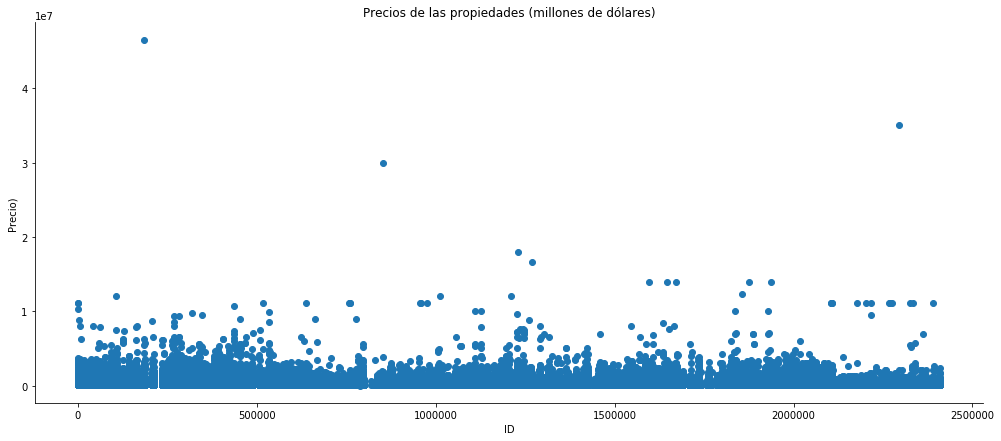

In [16]:
x = df.index
y = df['price']


fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Precios de las propiedades (millones de dólares)')
ax.set_ylabel('Precio)')
ax.set_xlabel('ID')
ax.scatter(x,y)

La gran mayoría de precios se encuentran debajo del millón de dólares. Veamos la distribución del precio:

In [17]:
df['price'].describe()

count    1.963350e+05
mean     2.597008e+05
std      4.249070e+05
min      2.040000e+04
25%      9.500000e+04
50%      1.500000e+05
75%      2.721250e+05
max      4.654544e+07
Name: price, dtype: float64

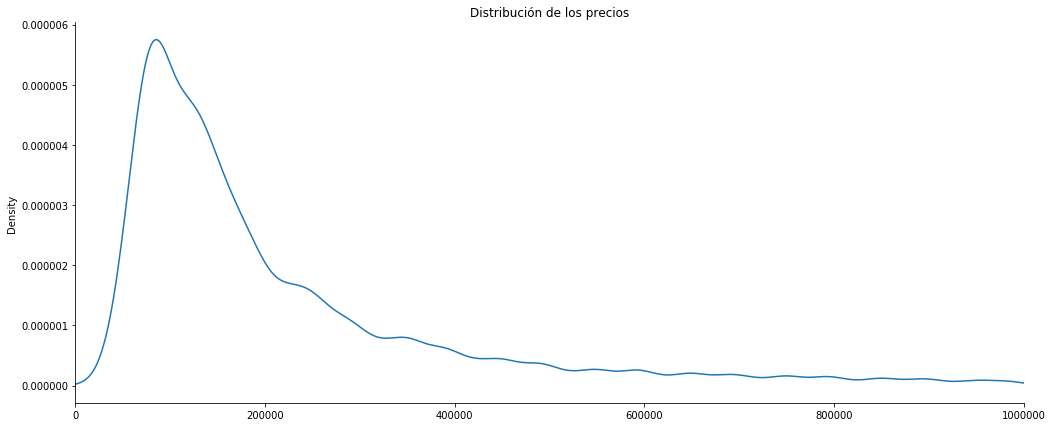

In [31]:
price = df[df['price'] < 1000000].price

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Distribución de los precios')
ax.axis(xmin=0, xmax=1000000)
price.plot.kde(ax=ax)

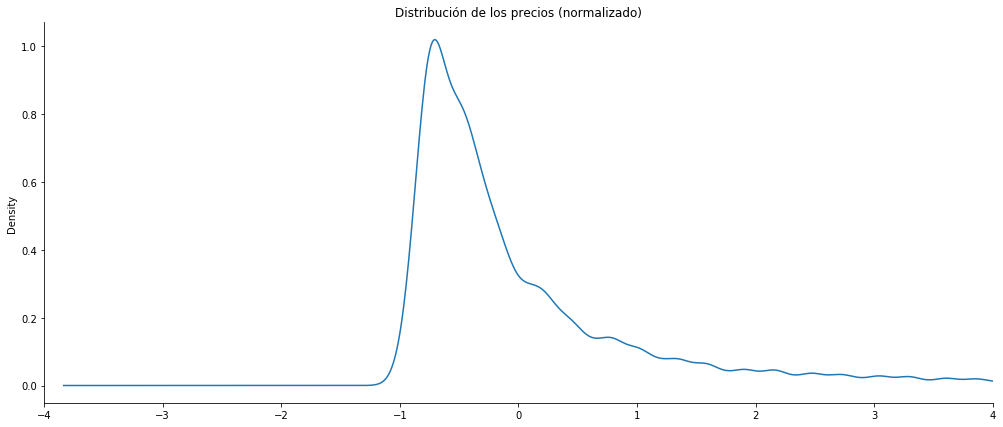

In [19]:
price = df[df['price'] < 1000000].price
price = (price - price.mean()) / price.std()

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Distribución de los precios (normalizado)')
ax.axis(xmin=-4, xmax=4)
price.plot.kde(ax=ax)

La mayoría de los precios están levemente por debajo de la media.

### Ordenamiento por Región
Las regiones están en la columna `place_with_parent_names` con el formato "Argentina|Capital Federal|Almagro|", guardo está informacion por separado

In [20]:
# Verifico que todos los rows tengan place definido
len(df.loc[df.place_with_parent_names.isnull() == True])

0

In [21]:
def split_region(x):
    state = x.split('|')[2]
    return state

def split_neighborhood(x):
    state = x.split('|')[3]
    return state

df['state'] = df.place_with_parent_names.apply(split_region)
df['barrio'] = df.place_with_parent_names.apply(split_neighborhood)

## Tipos de propiedades

In [22]:
df['property_type'].value_counts()

apartment    104045
house         68241
PH            18519
store          5530
Name: property_type, dtype: int64

Acá nos damos cuentas los tipos de propiedades existentes. La gran mayoría son departamentos o casas residenciales.

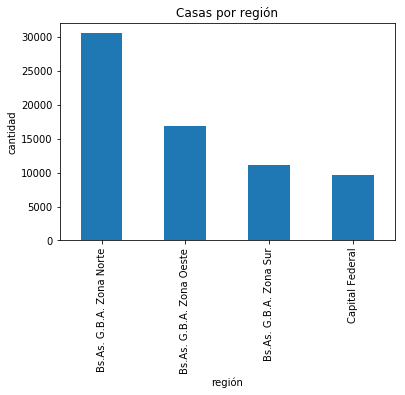

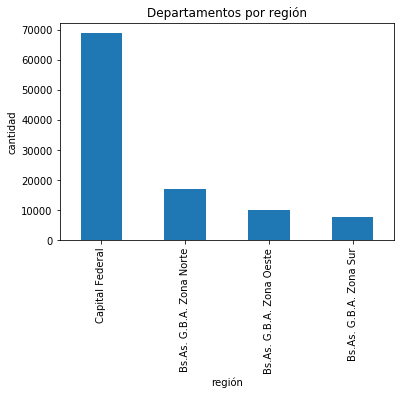

In [23]:
houses_by_state = df.loc[df['property_type'] == 'house']['state'].value_counts().plot(kind='bar')
houses_by_state.set_xlabel(u'región')
houses_by_state.set_ylabel('cantidad')
houses_by_state.set_title(u'Casas por región')
plt.show()
apartments_by_state = df.loc[df['property_type'] == 'apartment']['state'].value_counts().plot(kind='bar')
apartments_by_state.set_xlabel(u'región')
apartments_by_state.set_ylabel('cantidad')
apartments_by_state.set_title(u'Departamentos por región')
plt.show()

Como es de esperar, el grueso de las propiedades de tipo departamento están dentro de CABA, y las casas, afuera.

## Barrios más caros

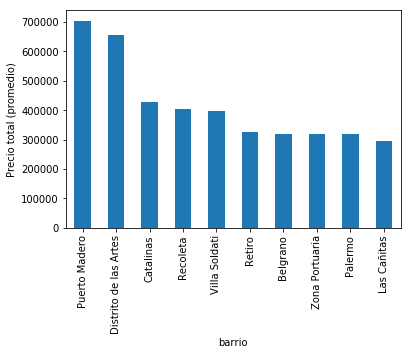

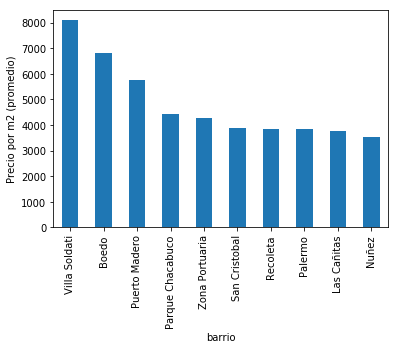

In [25]:
price = df.loc[df['state'] == 'Capital Federal'].loc[df['property_type'] == 'apartment'].groupby('barrio')['price'].mean().nlargest(10).plot(kind='bar')
price.set_ylabel("Precio total (promedio)")
plt.show()
price_per_m2 = df.loc[df['state'] == 'Capital Federal'].loc[df['property_type'] == 'apartment'].groupby('barrio')['price_per_m2'].mean().nlargest(10).plot(kind='bar')
price_per_m2.set_ylabel("Precio por m2 (promedio)")
plt.show()

Se puede observar que algunos barrios coinciden en ambos casos. En particular el primer gráfico es consistente con [fuentes externas](http://www.lanacion.com.ar/2059858-los-barrios-mas-caros-de-la-ciudad-para-alquilar-un-departamento-de-dos-ambientes)

In [26]:
df.loc[df['barrio'] == 'Distrito de las Artes']

,country_name,created_on,currency,expenses,floor,geonames_id,lat,lat-lon,lon,operation,...,price_aprox_usd,price_per_m2,property_type,rooms,surface_covered_in_m2,surface_in_m2,surface_total_in_m2,title,state,barrio
28928,Argentina,2016-04-12,ARS,NaN,NaN,NaN,-34.627617,"-34.6276174,-58.3606601",-58.360660,sell,...,157977.07,NaN,apartment,3.0,NaN,NaN,98.0,PUERTO PAMPA,Capital Federal,Distrito de las Artes
1388280,NaN,2015-10-06,USD,NaN,NaN,NaN,-34.627664,"-34.627664,-58.365153",-58.365153,sell,...,92000.00,NaN,apartment,3.0,NaN,58.0,NaN,Departamento - 3 Ambientes - Catalinas Sur,Capital Federal,Distrito de las Artes
1388869,NaN,2015-10-14,USD,NaN,NaN,NaN,-34.629606,"-34.629606,-58.364396",-58.364396,sell,...,45000.00,NaN,apartment,1.0,NaN,18.0,NaN,Departamento - 1 Ambiente - A metros de Parque...,Capital Federal,Distrito de las Artes
1390948,NaN,2015-10-29,USD,NaN,NaN,NaN,-34.627130,"-34.62713,-58.363244",-58.363244,sell,...,90500.00,NaN,apartment,3.0,NaN,55.0,NaN,Departamento - 3 Ambientes - La Boca,Capital Federal,Distrito de las Artes


In [27]:
df_deptos_caros_capital = df.dropna(subset=['lat', 'lon'], how='any').loc[(df.property_type.str.contains('apartment'))&(df.place_name == 'Capital Federal')].sort_values('price_per_m2',ascending=False).head(100)

### Correlación tamaño - precio de las propiedades

In [23]:
df.surface_total_in_m2.isnull().value_counts()

True     1779008
False     630463
Name: surface_total_in_m2, dtype: int64

In [24]:
df.surface_in_m2.isnull().value_counts()

True     1279201
False    1130270
Name: surface_in_m2, dtype: int64

In [28]:
def surface(x):
    if x.surface_total_in_m2:
        return x.surface_total_in_m2
    
    if x.surface_in_m2:
        return x.surface_in_m2
    
    if x.surface_covered_in_m2:
        return x.surface_covered_in_m2
    
    return 0

sf = df.apply(surface, axis=1)
sf.isnull().value_counts()

True     1816882
False     592589
dtype: int64

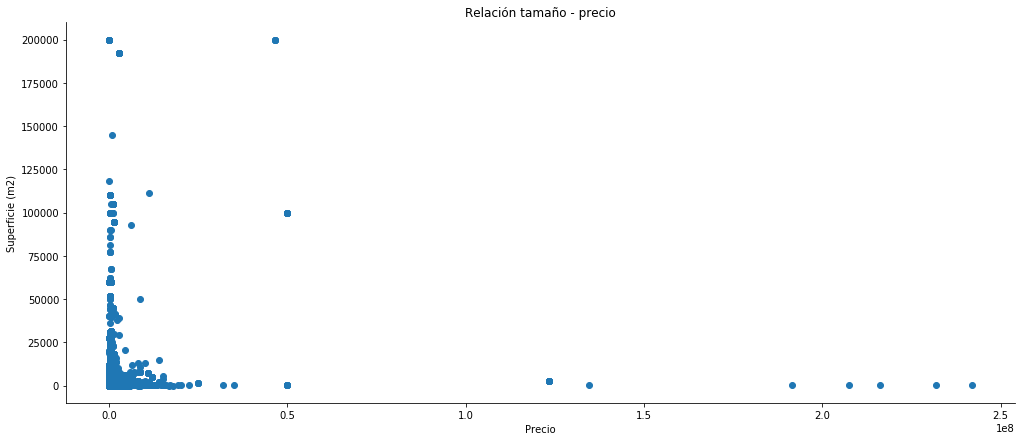

In [16]:
x = df.price
y = df.surface_total_in_m2

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Relación tamaño - precio')
ax.set_ylabel(u'Superficie (m2)')
ax.set_xlabel('Precio')
ax.scatter(x,y)

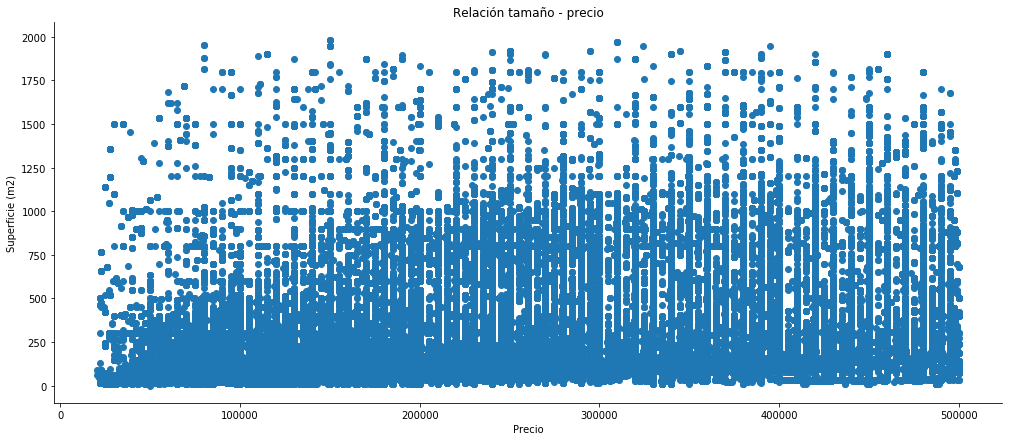

In [38]:
filtro = df.loc[(df.price < 500000) & (df.price > 20000)]
filtro = filtro.loc[(filtro.surface_total_in_m2 < 2000) & (filtro.surface_total_in_m2 > 0)]

x = filtro.price
y = filtro.surface_total_in_m2

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Relación tamaño - precio')
ax.set_ylabel(u'Superficie (m2)')
ax.set_xlabel('Precio')
ax.scatter(x,y)

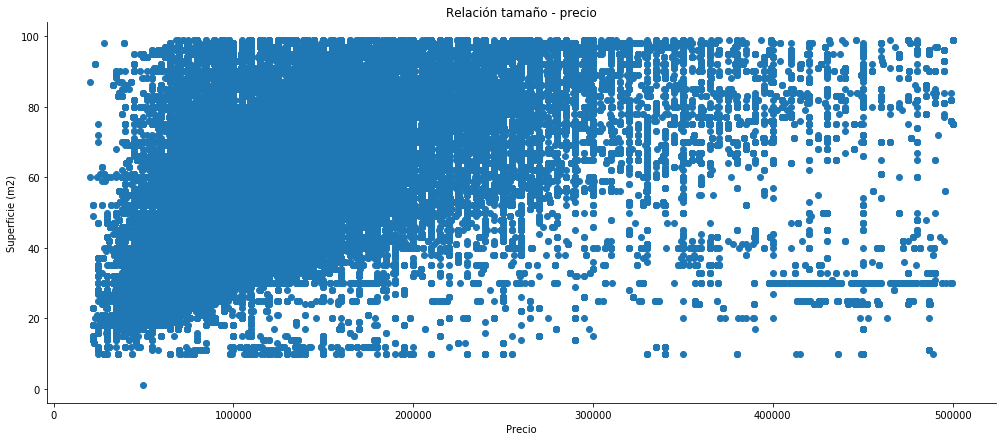

In [35]:
filtro = df.loc[(df.price < 500000) & (df.price > 20000)]
filtro = filtro.loc[(filtro.surface_total_in_m2 < 100) & (filtro.surface_total_in_m2 > 0)]

x = filtro.price
y = filtro.surface_total_in_m2

fig, ax = plt.subplots(figsize=(17, 7))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_title(u'Relación tamaño - precio')
ax.set_ylabel(u'Superficie (m2)')
ax.set_xlabel('Precio')
ax.scatter(x,y)


En el orden de superficies bajas se puede notar una relación entre el precio y el tamaño d

In [28]:
geometry = [Point(x,y) for x,y in zip(df_deptos_caros_capital['lon'], df_deptos_caros_capital['lat'])]

gs = GeoDataFrame(df_deptos_caros_capital, geometry=geometry)

In [29]:
gs.plot(marker='o', color='red', markersize=60, figsize=(4, 4))
mplleaflet.display()

In [30]:
df.loc[df['place_name'] == 'Capital Federal'].groupby('place_name')['price'].mean()

place_name
Capital Federal    228245.307188
Name: price, dtype: float64